In [2]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
!nvidia-smi

Mon Aug 15 16:53:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation,Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# Make the creating of our model a little easier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import Sequential
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
tf.__version__

'2.8.2'

In [5]:
# Avoid out of Memory errors by limiting GPU use
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [8]:
IMAGE_SIZE = [224, 224]
#passing the file paths into a variable name
train = "/content/drive/MyDrive/bird data/Train"
test = "/content/drive/MyDrive/bird data/Test"

In [9]:
#to check how many classes exist in the training set
folder = glob( "/content/drive/MyDrive/bird data/Train/*")
len(folder)

200

In [10]:
# Use the Image Data Generator to import the images from the dataset and normalise them
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1/255)

test_datagen = ImageDataGenerator(rescale = 1/255)


training = train_datagen.flow_from_directory("/content/drive/MyDrive/bird data/Train",
                                                 target_size = (224, 224),
                                                 batch_size = 200,
                                                 class_mode = 'categorical',
                                             shuffle = True)

test_set = test_datagen.flow_from_directory("/content/drive/MyDrive/bird data/Test",
                                            target_size = (224, 224),
                                            batch_size = 200,
                                            class_mode = 'categorical')

Found 16187 images belonging to 200 classes.
Found 2384 images belonging to 200 classes.


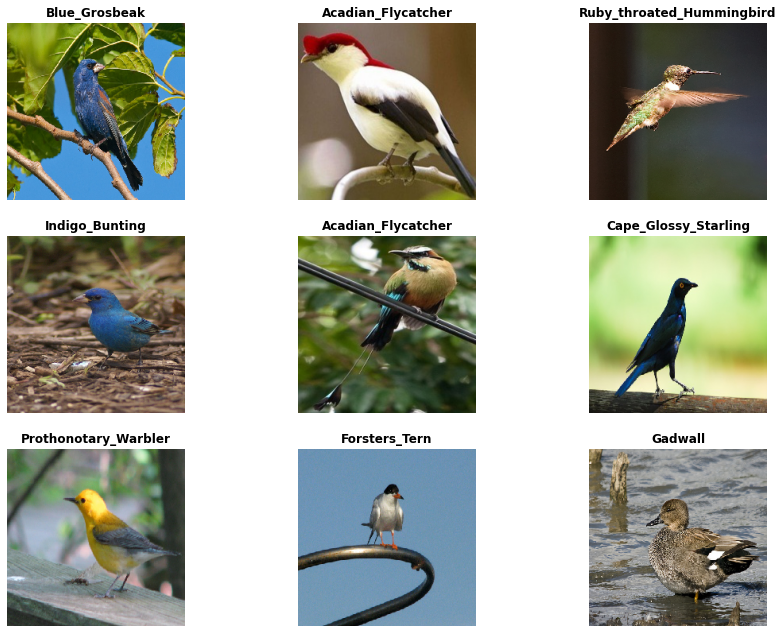

In [ ]:
fig = plt.figure(figsize=(20,15))
gs = fig.add_gridspec(4, 4)
#
for row in range(0, 3):
    for col in range(0, 3):
        image, label = training.next()
        label_id = list(label[0]).index(1)
        label_str = list(training.class_indices.keys())[list(training.class_indices.values()).index(label_id)]
        ax = fig.add_subplot(gs[row, col])
        ax.axis('off');
        ax.set_title(label_str, fontdict={"fontweight": 700})
        ax.imshow(image[0]);


In [11]:
 #data augmentation
#This would only be applied to my training data. looking at the data rotated within 40 degrees would give more data without a change to the mostly vertically sitting birds. 
Augment_datagen = ImageDataGenerator(rescale=1./255, rotation_range=90, # Rotate the images randomly by 40 degrees
    width_shift_range=0.5, # Shift the image horizontally by 50%
    height_shift_range=0.5, # Shift the image veritcally by 50%
    #zoom_range=0.2, # Zoom in on image by 20% 
    horizontal_flip=True, # Flip image horizontally 
    fill_mode='nearest',
    zoom_range=[0.5,1.0],
    brightness_range=[0.2,1.0]) 
Augmentation_train = Augment_datagen.flow_from_directory("/content/drive/MyDrive/bird data/Train", target_size=(224,224))

print('data groups:', len(Augmentation_train)) #Will be used to determine steps_per_epoch in my models.

Found 16187 images belonging to 200 classes.
data groups: 506


# New Section

In [12]:
model4 = Sequential()

model4.add(Conv2D(16, (3, 3), padding='same',input_shape= (224, 224, 3))) #224X224
model4.add(Activation('relu'))
model4.add(MaxPool2D(pool_size=(2, 2)))
model4.add(BatchNormalization())

model4.add(Conv2D(32, (3, 3))) #222x222
model4.add(Activation('relu'))
model4.add(MaxPool2D(pool_size=(2, 2))) #111x111
model4.add(BatchNormalization())

model4.add(Conv2D(64, (3, 3))) #222x222
model4.add(Activation('relu'))
model4.add(MaxPool2D(pool_size=(2, 2))) #111x111
model4.add(BatchNormalization())
model4.add(Dropout(0.35))

model4.add(Conv2D(128, (3, 3))) #222x222
model4.add(Activation('relu'))
model4.add(MaxPool2D(pool_size=(2, 2))) #111x111
model4.add(BatchNormalization())
model4.add(Dropout(0.35))

#model4.add(Conv2D(256, (3, 3))) #222x222
#model4.add(Activation('relu'))
#model4.add(MaxPool2D(pool_size=(2, 2))) #111x111
#model4.add(BatchNormalization())
#model4.add(Dropout(0.35))
#model4.add(Dropout(0.35)) #Doesn't appear to be working in the model summary.

model4.add(Conv2D(256, (3, 3), padding='same')) #54x54
model4.add(Activation('relu'))
#model4.add(MaxPool2D(pool_size=(2, 2)))
model4.add(BatchNormalization())

model4.add(Flatten()) 
model4.add(Dropout(0.5)) 
model4.add(Dense(512)) 
model4.add(Activation('relu'))
model4.add(BatchNormalization())

model4.add(Dense(200)) #Updated for number of classes
model4.add(Activation('softmax'))


In [13]:
model4.compile(optimizer = tf.keras.optimizers.SGD(lr=0.01),
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])
# Fit the model
history3 = model4.fit(Augmentation_train, # use augmented data
                          epochs=1,
                          steps_per_epoch=len(Augmentation_train ))
                          #validation_data=test_set,
                          #validation_steps=0.25*len(test_set))



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


506/506 [==============================] - 4358s 9s/step - loss: 4.5707 - accuracy: 0.3251


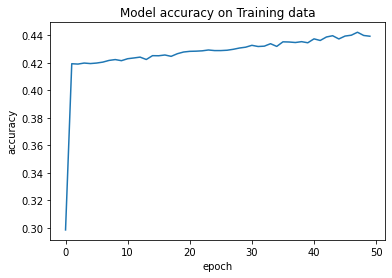

In [16]:

plt.plot(history3.history['accuracy'])
plt.title('Model accuracy on Training data')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.show()  

In [17]:
#Testing the model withe the test data
history4 = model4.fit(test_set, # use augmented data
                          epochs=50,
                          steps_per_epoch=len(test_set))

Epoch 1/25
12/12 [==============================] - 14s 1s/step - loss: 4.3152 - accuracy: 0.0713
Epoch 2/25
12/12 [==============================] - 14s 1s/step - loss: 4.2662 - accuracy: 0.0935
Epoch 3/25
12/12 [==============================] - 14s 1s/step - loss: 4.1638 - accuracy: 0.1149
Epoch 4/25
12/12 [==============================] - 14s 1s/step - loss: 4.0788 - accuracy: 0.1279
Epoch 5/25
12/12 [==============================] - 13s 1s/step - loss: 4.0286 - accuracy: 0.1414
Epoch 6/25
12/12 [==============================] - 13s 1s/step - loss: 3.9566 - accuracy: 0.1644
Epoch 7/25
12/12 [==============================] - 14s 1s/step - loss: 3.8693 - accuracy: 0.1812
Epoch 8/25
12/12 [==============================] - 14s 1s/step - loss: 3.7752 - accuracy: 0.2097
Epoch 9/25
12/12 [==============================] - 13s 1s/step - loss: 3.7147 - accuracy: 0.2282
Epoch 10/25
12/12 [==============================] - 13s 1s/step - loss: 3.6446 - accuracy: 0.2357
Epoch 11/25
12/12 [

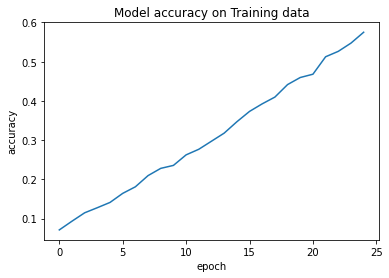

In [18]:

plt.plot(history4.history['accuracy'])
plt.title('Model accuracy on Training data')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.show()  